# Estimating Parameters for the RDPG

For this example, we'll work with the school example we've seen previously. The nodes are 100 students in total, from one of two schools. Here, the first 50 students are from the first school, and the second 50 students are from the second school. The probability of two students who both go to the first school being friends is $0.5$, and the probability of two students who both go to school two being friends will also be $0.5$. If two students go to different schools, their probability of being friends will be $0.2$. The statistical model has parameters which look like this:

In [20]:
import graspologic as gp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

ns1 = 50; ns2 = 50
ns = [ns1, ns2]

# zvec is a column vector of 50 1s followed by 50 2s
# this vector gives the school each of the 100 students are from
zvec = np.array(["S1" for i in range(0, ns1)] + ["S2" for i in range(0, ns2)])

# the block matrix
B = [[0.5, 0.3], [0.3, 0.5]]

# the probability matrix
zvec_ohe = np.vstack([[1, 0] for i in range(0, ns1)] + [[0, 1] for i in range(0, ns2)])
P = zvec_ohe @ B @ zvec_ohe.transpose()

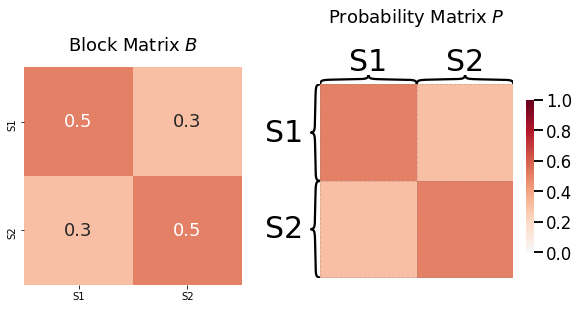

In [21]:
fig, axs = plt.subplots(1,2, figsize=(10,4))

gp.plot.heatmap(np.array(B), ax=axs[0], title="Block Matrix $B$", 
                xticklabels=["S1", "S2"], yticklabels=["S1", "S2"],
                cbar=False, annot=True, vmin=0, vmax=1)
gp.plot.heatmap(P, ax=axs[1], inner_hier_labels=zvec,
                title="Probability Matrix $P$", vmin=0, vmax=1);

The procedure for generating the probability matrix from the block probability matrix that we used above is a linear algebra "cheat", but in reality, all that's happening is that we are comparing whether two nodes are in the first or the second school, and then taking the appropriate entry from the block matrix accordingly. The operation is exactly the same as we had in the section on RDPG. For two nodes $i$ and $j$, the probability they are connected is:
\begin{align*}
    p_{ji} = p_{ij}, p_{ij} = \begin{cases}
        b_{11} & z_i = 1, z_j = 1 \\
        b_{12} & z_i = 1, z_j = 2 \\
        b_{22} & z_i = 2, z_j = 2
    \end{cases}
\end{align*}

Next, we will use this probability matrix and the corresponding community assignment vector to generate a realization of the stochastic block model we saw above. This is our "real network":

In [22]:
A = gp.simulations.sbm(ns, B, directed=False, loops=False)

You can see the adjacency matrix and the probability matrix below. Notice that there are two distrinct blocks in the adjacency matrix, which are shared with the probability matrix: in its upper-left, you can see the edges between the first 50 nodes (the individuals in the first school), and in the bottom right, you can see the edges between the second 50 nodes (the individuals in the second school).

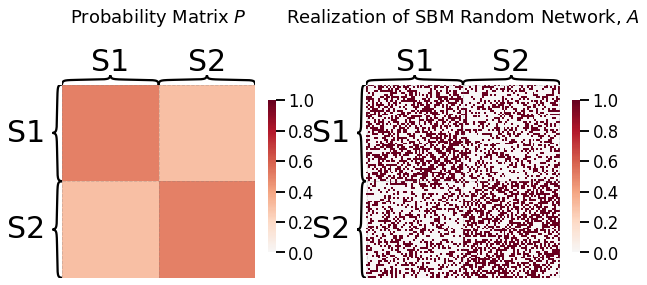

In [23]:
fig, axs = plt.subplots(1,2, figsize=(10,4))

gp.plot.heatmap(P, ax=axs[0], inner_hier_labels=zvec,
                title="Probability Matrix $P$", vmin=0, vmax=1);
gp.plot.heatmap(A, ax=axs[1], inner_hier_labels=zvec,
                title="Realization of SBM Random Network, $A$", vmin=0, vmax=1);

As we can see, both the probability matrix $P$ and the realization of the random network $A$ both have a notable "structure", in that it's clear that there are more nodes when both individuals are in the first school (the top left and bottom right "squares" of the adjacency matrix and probability matrix have more entries and are darker, respectively) and fewer nodes when both individuals are in different schools (the top right and bottom left "squares" of the adjacency matrix have fewer entries and are lighter, respectively). 

## How are nodes from the same community similar?

As it turns out, there's a really important property that is shared by nodes in an SBM random network. Remember that the probability matrix $P$ gives the probabilities $p_{ji}$ of each pair of nodes $i$ and $j$ of being connected. We're going to introduce a new piece of notation here, called the *vector of probabilities* for a single node. The **vector of probabilities** for a node $i$ is the quantity:

\begin{align*}
    \vec p_i &= \begin{bmatrix}
        p_{i1} \\
        \vdots \\
        p_{in}
    \end{bmatrix}
\end{align*}

In words, it is basically just the $i^{th}$ row of the probability matrix $P$. Now, what happens when we look at the probability vectors for nodes which are in the same, versus different communities? Here, what we will do is take the probability vectors for students $1$ and $2$, who both attend school one, and compare them to the probability vectors for students $51$ and $52$, who both attend school two:

In [24]:
# grab the probability vectors for the students we outlined above
Psubset = P[[0, 1, 50, 51],:]

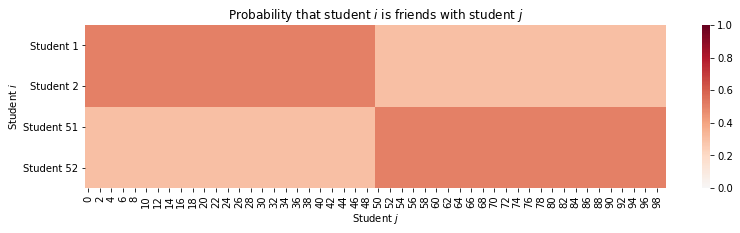

In [25]:
fig, ax = plt.subplots(1,1, figsize=(13, 3))
sns.heatmap(Psubset, ax=ax, cmap='RdBu_r', vmin=0, center=0, vmax=1,
           yticklabels=["Student 1", "Student 2", "Student 51", "Student 52"])
ax.set_title("Probability that student $i$ is friends with student $j$")
ax.set_ylabel("Student $i$")
ax.set_xlabel("Student $j$");

The probability vectors for students $1$, $2$, $51$, and $52$ are shown as the rows of the above heatmap. What do we notice about the probability vectors for students $1$ and $2$ in comparison to students $51$ and $52$? As it turns out, they are exactly the same, and the probability vectors are identical! In general, what this means is that, for an SBM, *all* of the nodes in a single community have the *exact same* probability vector! If you are interested in some more details as to why this is the case for an SBM, the reason is that the probability vector for a given node is *fully specified* by just knowing the block matrix and the community assignment vector for the nodes in the network. What this means is that there is nothing special about one node versus another node in the same community, in the probability sense.

Now, what does this mean for *us*? What this means is that the probability matrix has a special property, called the *low-rank* property. Now, we'll learn about matrix rank, and some important consequences of this fact.

## Low-rank structure: what it is, how we find it, and why it matters

### Matrix Rank

In the technical sense, the *rank* of a matrix is a description of just how complicated the matrix is. A matrix is **low rank** if any of its rows (or equivalently, its columns) are linear combinations of other rows (or columns). What this means is that if we can take rows or columns from the matrix, and add or multiply them together to get other rows or columns from the matrix, the matrix is low rank. This means that information contained in the matrix is redundant, in that we could obtain it by just adding or subtracting other information already contained in the matrix!

In our case, what this means is that the probability matrix for an SBM with $K$ total communities will be of rank-$K$: there is a single unique probability vector for each community. This means that we could express all of the rows of the probability matrix by taking one probability vector from each community, and then "instructions" as to how we combine these probability vectors to obtain the probability vectors for other nodes in the community. In the case of the simple SBM, these "instructions" are just to duplicate the same vector over and over again, for every node in the community. Nothing too complicated, right?

### How do we find this low-rank structure?

When we have data which we think is low-rank, one way we can identify this pattern is by using something called a *spectral embedding*. This embedding is called *spectral* because it will have to do with the eigenvalues/eigenvectors of the probability matrix (often called a matrix's *spectrum*). It is called an *embedding* which, informally, means that there is a high level structure that we get to see (the probability matrix) which can be more succinctly described by a lower-level structure that we don't immediately get to see (the two unique probability vectors). What we want to do here is identify this low-level structure given the probability matrix and *nothing else*, which means we might not get to see the communities each node is part of when we perform this analysis. The spectral embedding will let us do this.

#### The Singular Value Decomposition

The spectral embedding algorithm begins by finding the *singular-value decomposition* of the data.

```{admonition} Singular-Value Decomposition
The singular value decomposition of a matrix $P$ is the set of matrices $U, \Sigma$, and $V$, where:
\begin{align*}
    P &= U\Sigma V^\top
\end{align*}
where $U$, $\Sigma$, and $V$ have some special properties:
1. The left singular vectors: the columns $\vec u_i$ of $U$ are called the left singular vectors of $P$. If $P$ has $n$ rows and $n$ columns, there will be $n$ left singular vectors. This matrix looks like this:
\begin{align*}
    U &= \begin{bmatrix}
        \vec u_1 & ... & \vec u_n
    \end{bmatrix}
\end{align*}

2. The singular values: the matrix $\Sigma$ is a diagonal matrix, which means that it has entries along the diagonal and all the other entries are just *zero*. There will be $n$ total of these. This matrix looks something like this:
\begin{align*}
    \Sigma &= \begin{bmatrix}
        \sigma_1 & 0 & ... & 0 \\
        0 & \sigma_2 & \ddots & \vdots \\
        \vdots & \ddots & \ddots & 0 \\
        0 & ... & 0 & \sigma_n
    \end{bmatrix}
\end{align*}
The special property is that by definition, the singular values are *descending*, in that $\sigma_1 \geq \sigma_2$, $\sigma_2 \geq \sigma_3$, so on and so forth to $\sigma_n$.

3. The right singular vectors: the columns $\vec v_i$ of $V$ are called the right singular vectors of $P$. If $P$ has $n$ rows and $n$ columns, there will be $n$ right singular vectors. This matrix looks like this:
\begin{align*}
V &= \begin{bmatrix}
    \vec v_1 & ... & \vec v_n
\end{bmatrix}
\end{align*}
```

As it turns out, because $\Sigma$ is a diagonal matrix, the multiplication $P = U\Sigma V^\top$, which to the author anyways is somewhat opaque, can actually be written a lot more easily. We can write this equation down like this, which is much more understandable:
\begin{align*}
    P &= \sum_{i = 1}^n \sigma_i \vec u_i \vec v_i^\top = \sum_{i = 1}^n \sigma_i\begin{bmatrix}
        \uparrow \\ \vec u_i \\ \downarrow
    \end{bmatrix}\begin{bmatrix}
        \leftarrow & \vec v_i^\top & \rightarrow
    \end{bmatrix}
\end{align*}
In a sense, what this means is that $P$ is a sum of the products of $\vec u_i$ with $\vec v_i^\top$, and then "scaled" or "multiplied" by $\sigma_i$.

To show this computationally, we're going to decompose $P$ into its singular value decomposition using `numpy`. We'll first show something called a scree plot, which is a plot of the singular values of the matrix $P$. This plot is typically shown by having the magnitude of each singular value on the $y$-axis, and the $x$-axis is just the index of the singular value. Remember, the singular values are *descending*, which means that this plot is always going to show the singular values *decreasing* as the index increases.

In [26]:
# take the singular value decomposition
U, s, Vt = np.linalg.svd(P)
# U is the matrix whose columns are the left singular vectors
# s is the vector whose entries are the singular values
# Vt is the matrix whose rows are the right singular vectors
# and whose tranpose has columns which are the right singular vectors

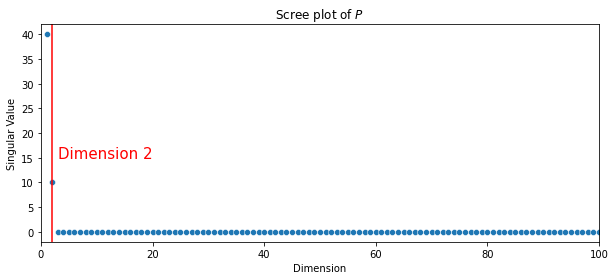

In [27]:
from pandas import DataFrame
def plot_scree(svs, title="", ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(10, 4))
    sv_dat = DataFrame({"Singular Value": svs, "Dimension": range(1, len(svs) + 1)})
    sns.scatterplot(data=sv_dat, x="Dimension", y="Singular Value", ax=ax)
    ax.set_xlim([0, len(s)])
    ax.set_xlabel("Dimension")
    ax.set_ylabel("Singular Value")
    ax.set_title(title)
    ax.axvline(x=2, color='r')
    ax.text(x=3, y=15, s="Dimension 2", color='r', size=15)

plot_scree(s, title="Scree plot of $P$")

Next, we'll show $P$ itself, the matrix product of $U$, $\Sigma$, and $V^\top$, followed by the sum expression to show you we aren't just making up that all of these expressions are exactly equal!

In [28]:
# matrix product form of expression for P
Psvd = U @ np.diag(s) @ Vt

# sum expression for P
# remember that U[:,i] is the ith column of U (the ith left singular vector)
# and Vt[i,:] is the ith column of V (the ith right singular vector)
# and the ith row of Vt (transpose)
Psum = np.sum([s[i]*np.array(U[:,[i]]) @ np.array(Vt[[i],:]) for i in range(0, ns1 + ns2)], 0)

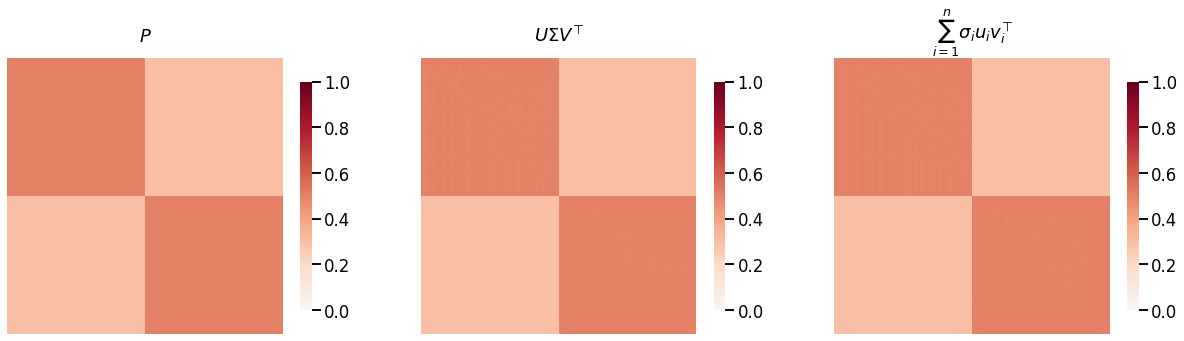

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(21, 6))
 
gp.plot.heatmap(P, ax=axs[0],
                title="$P$", vmin=0, vmax=1);
gp.plot.heatmap(Psvd, ax=axs[1],
                title="$U\\Sigma V^\\top$", vmin=0, vmax=1);
gp.plot.heatmap(Psum, ax=axs[2],
                title="$\\sum_{i = 1}^n \sigma_i u_i v_i^\\top$", vmin=0, vmax=1);

#### The relationship between the singular value decomposition and "best" representations of a matrix

What if we only looked at the first $d$ entries of the singular value decomposition? When we say "look at", what we mean is that we will retain the first $d$ left and right singular values/vectors, and the first (the *biggest*) $d$ singular values. We will call this new matrix $P_d$:
\begin{align*}
    P_d &= \sum_{i = 1}^d \sigma_i \vec u_i \vec v_i^\top
\end{align*}
Again, we can write this up in full matrix form, as $P_d = U_d\Sigma_d V_d^\top$, where $U_d$ is now just the first $d$ columns of $U$, $\Sigma_d$ is just the diagonal matrix from the first $d$ singular values, and $V_d$ is the first $d$ columns of $V$. Another special property of the singular value decomposition that we will need is that, as it turns out, the $U_d$, $\Sigma_d$, and $V_d$ that we constructed in this way are the *best* possible choices we could have made to represent $P$ using $d$ singular values and vectors. By best, we mean that if we were to any other scalar multiples $\sigma_i$, and singular values/vectors $\vec u_i$ and $\vec v_i$, the matrix we would make using the sum shown above is not going to be as similar to $P$ as $P_d$ is (more specifically, the Frobenius difference between $P$ and $P_d$ will be *minimal*). This is just a definition of the singular value decomposition, and is not anything super technical beyond that, so you shouldn't worry too much about this fact and just take our word on it for now.

What does $\sigma_i$ mean for us? Well, if we were to look at $P_1$, $P_1$ would just be $\sigma_1 \vec u_1 \vec v_1^\top$, so it's pretty clear that $\vec u_1$ and $\vec v_1$ are the best singular vectors to describe $P$. $\sigma_1$ basically just tells us how much we should multiply them to describe $P$ just right. Let's take a look at $P_1$:

In [30]:
P1 = s[0]*np.array(U[:,[0]]) @ np.array(Vt[[0],:])
diff = np.linalg.norm(P - P1)  # compute the frobenius difference

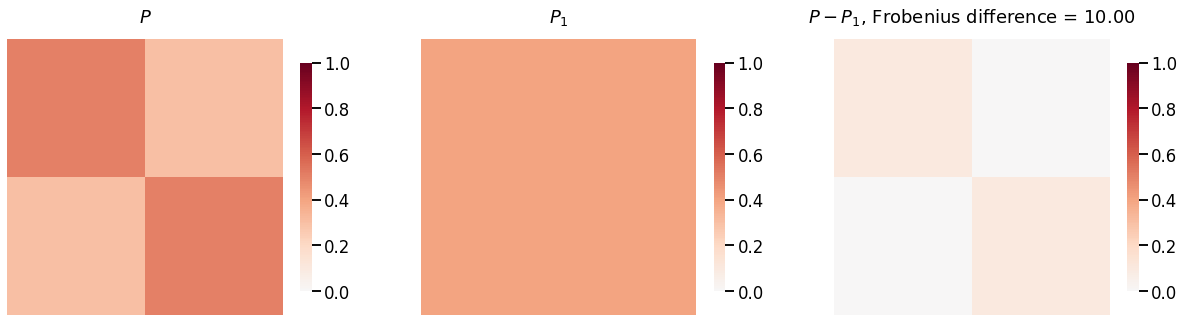

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(21, 6))

gp.plot.heatmap(P, ax=axs[0],
                title="$P$", vmin=0, vmax=1);
gp.plot.heatmap(P1, ax=axs[1],
                title="$P_1$", vmin=0, vmax=1);
gp.plot.heatmap(P - P1, ax=axs[2],
                title="$P - P_1$, Frobenius difference = {:.2f}".format(diff), vmin=0, vmax=1);

How about $P_2$? Well we knew that $P_1$ was the best representation with $1$ singular values and vectors, and now we just add in $\sigma_2 \vec u_2 \vec v_2^\top$ to get $P_2$. That is:
\begin{align*}
    P_2 &= \sum_{i = 1}^2 \sigma_i \vec u_i \vec v_i^\top + \sigma_2 \vec u_2 \vec v_2^\top = P_1 + \sigma_2 \vec u_2 \vec v_2^\top
\end{align*}
So now $\sigma_2$ is the multiplicative factor telling us how much to multiply $\vec u_2$ and $\vec v_2$ by. If we repeat this over and over, we will see that the singular values $\sigma_i$ will just describe how much we need to multiply $\vec u_i$ and $\vec v_i$ by to offset the preceding "best" matrix with $i-1$ singular values and vectors to get the best representation with $i$ singular values and vectors. If $\sigma_i$ were big, then $\vec u_i$ and $\vec v_i^\top$'s product will be a big component of $P_i$. If $\sigma_i$ were small, then $\vec u_i$ and $\vec v_i^\top$'s product will not be a very big compouent of the sum we have here. So the entry $\sigma_i$, in effect, tells us *just how important* the $i^{th}$ singular vectors are to $P$. This fact will be crucial later on.

#### Equivalence of top left and right singular vectors

You might be thinking this expression looks complicated, which we agree, so far it does. But there are some nice facts that will make this expression way simpler for us. As a rule of thumb, if a matrix is rank $d$, then *all* but the first $d$ singular values are just going to be zero. Since our probability matrix was rank-$K$, this means that:
\begin{align*}
    P &= \sum_{i = 1}^d \sigma_i \vec u_i \vec v_i^\top \\
    &= \sum_{i = 1}^K \sigma_i \vec u_i \vec v_i^\top + \sum_{i = K+1}^{n}\sigma_i \vec u_i \vec v_i^\top \\
    &= \sum_{i = 1}^K \sigma_i \vec u_i \vec v_i^\top \\
    &^= P_K
\end{align*}
in the second line, we just split the sum from $n$ terms apart into the first $K$ terms and the second $n - K$ terms as separate expressions. Then, we used the fact that the last $n-K$ singular values are all just $0$, so the $\vec u_i$s and $\vec v_i$s don't matter at *all*. So we can describe $P$ fully using *only* the first $K$ singular values and vectors. Again, we'll show this with `numpy`:

In [32]:
K = 2
UK = U[:,0:K]; SK = np.diag(s[0:K]); VtK = Vt[0:K,:]
PK = UK @ SK @ VtK
diff = np.linalg.norm(P - PK)  # compute the frobenius difference

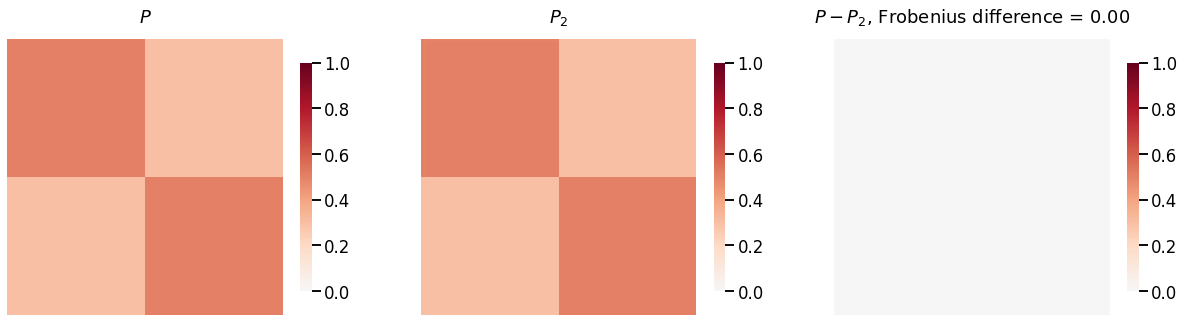

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(21, 6))

gp.plot.heatmap(P, ax=axs[0],
                title="$P$", vmin=0, vmax=1);
gp.plot.heatmap(PK, ax=axs[1],
                title="$P_2$", vmin=0, vmax=1);
gp.plot.heatmap(P - PK, ax=axs[2],
                title="$P - P_2$, Frobenius difference = {:.2f}".format(diff), vmin=0, vmax=1);

Next comes the really cool part. The matrix $P$ is square because it has $n$ rows and $n$ columns. The matrix is positive, because every entry is a probability between $0$ and $1$. Finally, the matrix is symmetric, because the underlying random network is undirected, which means that the probability of node $i$ being connected to node $j$ is equal to the probability that node $j$ is connected to node $i$. When a matrix is square, symmetric, and positive, for any singular vector associated with a non-zero singular value, the left and right singular vectors will be *identical*! This means that for *all* of the first $K$ singular vectors $\vec u_i$ and $\vec v_i$, that $\vec u_i = \vec v_i$! Using what we learned above, our expression for $P$ now looks like this:
\begin{align*}    
    P = P_K = \sum_{i = 1}^K \sigma_i \vec u_i \vec u_i^\top
\end{align*}
and putting this back in our matrix form with $U_K$ the matrix whose $K$ columns are the vectors $\vec u_i$, and $\Sigma_K$ the first $K$ singular values, we have that:
\begin{align*}
    P &= U_K \Sigma_K U_K^\top
\end{align*}
Now, we are really starting to get somewhere! Again, we'll show this using `numpy`:

In [34]:
# Psymm is UK * SigmaK * UK^transpose
Psymm = UK @ SK @ UK.transpose()
diff = np.linalg.norm(P - Psymm)  # compute the frobenius difference

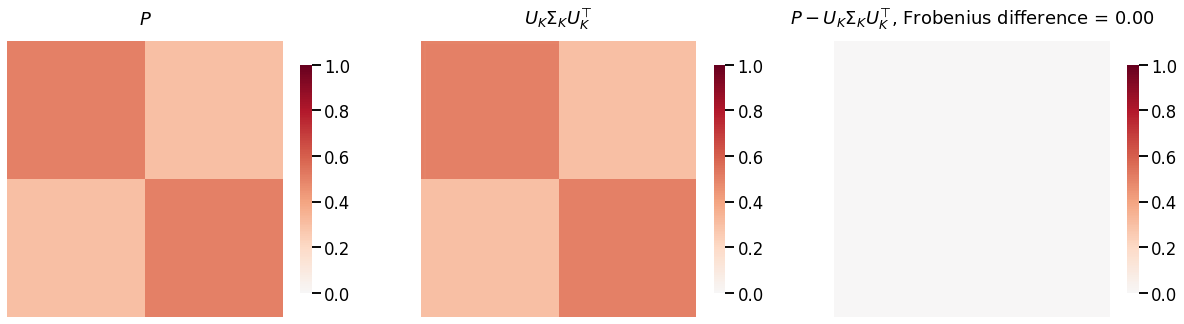

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(21, 6))

gp.plot.heatmap(P, ax=axs[0],
                title="$P$", vmin=0, vmax=1);
gp.plot.heatmap(PK, ax=axs[1],
                title="$U_K \\Sigma_K U_K^\\top$", vmin=0, vmax=1);
gp.plot.heatmap(P - PK, ax=axs[2],
                title="$P - U_K \\Sigma_K U_K^\\top$, Frobenius difference = {:.2f}".format(diff), vmin=0, vmax=1);

#### The Square Root Matrix

It's been quite a ride; don't fall off just yet! Now we are really in the home stretch! We've saved the easiest part for last. Remember that $\Sigma_K$ is just a diagonal matrix, whose entries are the singular values $\sigma_i$ for the first $K$ singular values. As it turns out, since $P$ is positive, these singular values are going to be positive too. This means that $\sigma_i$ has a real square root, since all positive numbers have a square root. This means we could just express $\sigma_i$ as the product of $\sqrt{\sigma_i}\sqrt{\sigma_i}$ with itself!

Finally, remember that if we were to multiply two diagonal matrices, the resulting matrix would just be the element-wise product of each diagonal entry. This means we could just write $\Sigma_K$ like this:
\begin{align*}
    \Sigma_K &= \begin{bmatrix}
        \sqrt{\sigma_1} & 0 & ... & 0 \\
        0 & \sqrt{\sigma_2} & \ddots & \vdots \\
        \vdots & \ddots & \ddots & 0 \\
        0 & ... & 0 & \sqrt{\sigma_n}
    \end{bmatrix}\begin{bmatrix}
        \sqrt{\sigma_1} & 0 & ... & 0 \\
        0 & \sqrt{\sigma_2} & \ddots & \vdots \\
        \vdots & \ddots & \ddots & 0 \\
        0 & ... & 0 & \sqrt{\sigma_n}
    \end{bmatrix}
\end{align*}
We will call the resulting matrix the "square root" matrix of $\Sigma_K$, abbreviated $\sqrt{\Sigma_K}$ which hopefully is named for pretty obvious reasons. So, $\Sigma_K = \sqrt{\Sigma_K}\sqrt{\Sigma_K}$. This matrix has $K \times K$ entries, and is therefore square. Also, notice that all the off-diagonal entries are just $0$, which means it's symmetric too, because of the convenient fact that $0 = 0$ (and hence, the off-diagonal entries are all equal). Putting this fact together means that $\sqrt{\Sigma_K} = \sqrt{\Sigma_K}^\top$, which is the definition of matrix symmetry. So finally, $\Sigma_K = \sqrt{\Sigma_K}\sqrt{\Sigma_K}^\top$. Putting this fact together gives us that:
\begin{align*}
    P &= U_K \sqrt{\Sigma_K}\sqrt{\Sigma_K}^\top U_K^\top
\end{align*}
If we let $X = U_K \sqrt{\Sigma_K}$, then $P = XX^\top$. This means that $X$ is a latent position matrix for $P$! If you remember back to the [Section on RDPGs](#link?), this means that we have found the latent position parameter for the corresponding RDPG for our SBM random network!

Let's see this using numpy again:

In [36]:
SKsqrt = np.sqrt(SK)
X = UK @ SKsqrt
Prdpg = X @ X.transpose()
diff = np.linalg.norm(P - Prdpg)  # compute the frobenius difference

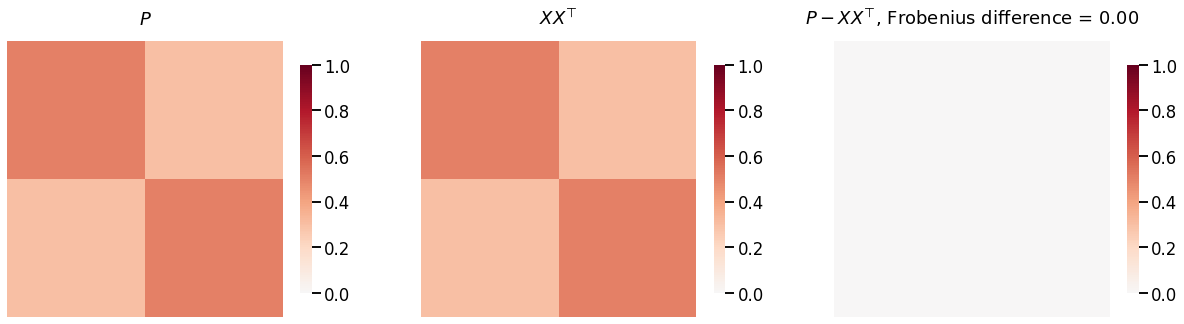

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(21, 6))

gp.plot.heatmap(P, ax=axs[0],
                title="$P$", vmin=0, vmax=1);
gp.plot.heatmap(Prdpg, ax=axs[1],
                title="$XX^\\top$", vmin=0, vmax=1);
gp.plot.heatmap(P - Prdpg, ax=axs[2],
                title="$P - XX^\\top$, Frobenius difference = {:.2f}".format(diff), vmin=0, vmax=1);

This matrix $X$, the latent position matrix, for an SBM will look like this:

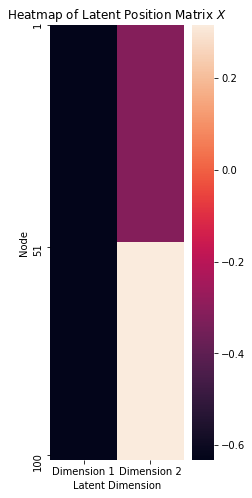

In [38]:
def plot_lpm(D, ax=None, title="", xticks=[], xticklabs=[],
            yticks=[], yticklabs=[], cbar=True):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3,8))
    sns.heatmap(D, ax=ax, cbar=cbar)
    ax.set_xlabel("Latent Dimension")
    ax.set_ylabel("Node")
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabs)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabs)
    ax.set_title(title);

plot_lpm(X, xticks=[0.5, 1.5], xticklabs=["Dimension 1", "Dimension 2"],
        yticks=[0, 51, 99], title="Heatmap of Latent Position Matrix $X$",
        yticklabs=["1", "51", "100"])

and is the "low-rank structure" which describes the probability matrix.

```{admonition} Putting it all together
What have we learned so far? What we've learned so far is that, if we have a probability matrix that is symmetric and rank-$K$:
1. We can decompose this probability matrix using the singular value decomposition.
2. We can ignore singular values/vectors other than the first $K$ of them.
3. For the first $K$ singular vectors, the left and right vectors are identical.
4. We can decompose the singular value matrix into the product of the square root matrix with its transpose.
5. We can express the matrix $P$ using the latent position matrix $X$, which is the product of the first $K$ singular vectors with the first $K$ singular values.
This means that we have found a latent position matrix $X$ for the probability matrix using the singular values and singular vectors of $P$, by effectively just discarding the ones that don't matter (and have singular values of $0$). We have succeeded in our goal of finding a much lower rank structure, the latent position matrix $X$, to describe the probability matrix $P$.
```

If you remember from the section on RDPGs, this probability matrix has the property that each entry $p_{ij} = \vec x_i \vec x_j^\top$.

## But wait: we don't have the probability matrix! What do we do?

All of the logic we developed above was with respect to the probability matrix, $P$, for a SBM. More generally, this logic extends to the probability matrix $P$ for any RDPG, which is because an RDPG with $d$ latent dimensions will *always* have a probability matrix that is *exactly* rank $d$. But, we have a slight issue: when we perform machine learning, we don't know the probability matrix! All we have is the adjacency matrix itself, $A$, which is our data! We don't actually know what the underlying probability matrix is! How the heck can we find this low rank structure we want to be able to estimate?

As it turns out, if we kept obtaining more and more networks $A$ from the underlying RDPG random network $\mathbf A$, we would *expect* that the network $A$ we saw would be the probability matrix $P$. We'll explain what we mean by expect here by turning back to our coin flip example. As you remember, we perform a coin flip at each pair of nodes $i$ and $j$ of an RDPG, where the coin lands on heads with probability $\vec x_i\vec x_j^\top$, and lands on tails with probability $1 - \vec x_i\vec x_j^\top$. This means we can *expect* the coin to land on heads with probability $\vec x_i\vec x_j^\top$. In the same sense, we can expect the $(i,j)$ entry of the adjacency matrix $A$ to exist with probability $\vec x_i \vec x_j^\top$. In this sense, the expected value of the adjacency matrix $A$ *is* the probability matrix $P = XX^\top$. 

So, since the expected value of the adjacency matrix *is* the probability matrix, what if we were to just embed the adjacency matrix instead? Let's see how this might work. Again, we'll use the singular value decomposition on $A$, and take a look at the scree plot for $A$, and compare it to the scree plot of $P$:

In [39]:
UA, sA, VAt = np.linalg.svd(A)

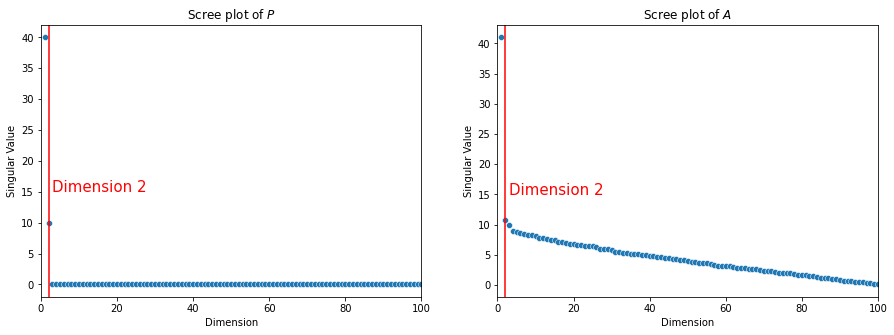

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
plot_scree(s, title="Scree plot of $P$", ax=axs[0])
plot_scree(sA, title="Scree plot of $A$", ax=axs[1])

Now that's really funky! The singular values of both $P$ and $A$ tend to fall off around *roughly* the same spot, right around dimension $2$! The singular value of $P$ go directly to $0$, but the singular values for $A$ tend to "round off" in the direction of $0$, but it isn't *too* far off!

As it turns out, this is no coincidence: the singular values for a network which can be described by an RDPG will tend to "elbow" off right around the number of true latent dimensions for the probability matrix of the underlying random network. If the RDPG has $d$ latent dimensions, this will occur right around $d$. For this reason, it is usually a good idea when we think a network might be well described by an RDPG to let the elbow selection algorithm do the work for us, and then take a good look at the scree plot to make sure the number of latent dimensions chosen seems reasonable to us.

What does it look like when we use the spectral embedding on $A$? We'll compare the embedding of the adjacency matrix to the latent positions of the probability matrix:

In [62]:
UAK = UA[:,0:K]; USK = np.diag(np.sqrt(sA[0:K]))
Aembedded = UAK @ USK

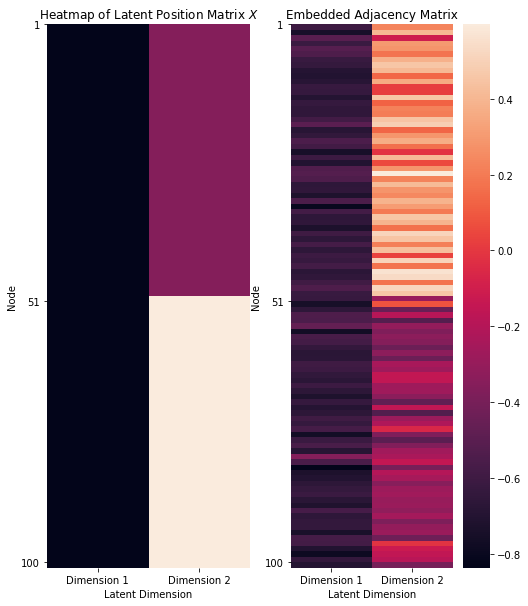

In [63]:
fig, axs = plt.subplots(1,2, figsize=(8, 10))

plot_lpm(X, xticks=[0.5, 1.5], xticklabs=["Dimension 1", "Dimension 2"],
        yticks=[0, 51, 99], title="Heatmap of Latent Position Matrix $X$",
        yticklabs=["1", "51", "100"], ax=axs[0], cbar=False)

plot_lpm(Aembedded, xticks=[0.5, 1.5], xticklabs=["Dimension 1", "Dimension 2"],
        yticks=[0, 51, 99], title="Embedded Adjacency Matrix",
        yticklabs=["1", "51", "100"], ax=axs[1])

Wow! When we take the adjacency matrix and embed it into $2$ dimensions, it doesn't look *identical* to the latent position matrix, but it shares some major patterns with it! In particular, it looks like the second latent dimension for the embedded adjacency matrix tends to capture that the second latent dimension of $X$ has higher values for the first $50$ nodes, and lower values for the second $50$ nodes. For a variety of reasons, we will call this "embedding of $A$" an *estimate* of the latent position matrix for the underlying RDPG, which we will denote by $\hat X$. 

As we learned in the last section, this entire procedure is automated for us by `graspologic` with the `AdjacencySpectralEmbed()` class, or alternatively, the `RDPGEstimator()`. The `RDPGEstimator()` class just makes clear that we are estimating parameters for an RDPG:

In [64]:
rdpgest = gp.models.RDPGEstimator()
rdpgest = rdpgest.fit(A)
Xhat = rdpgest.latent_

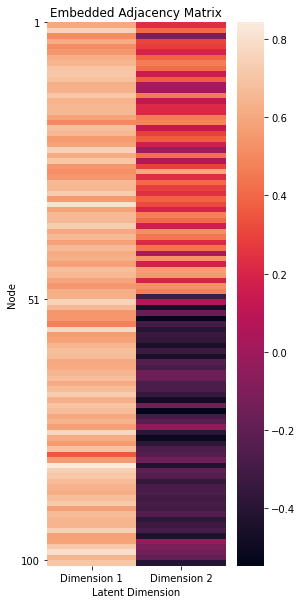

In [65]:
fig, ax = plt.subplots(1,1, figsize=(4, 10))

plot_lpm(Xhat, xticks=[0.5, 1.5], xticklabs=["Dimension 1", "Dimension 2"],
        yticks=[0, 51, 99], title="Embedded Adjacency Matrix",
        yticklabs=["1", "51", "100"], ax=ax)

As it turns out, this example here is a good instance of another property of the latent position matrix. Remember that the latent position matrix is the matrix $X$ where $P = XX^\top$. As it turns out, sometimes the columns of this matrix can get flipped around a little bit, through something called a rotation. You can see this by noticing that it looks a lot like the entries of the estimates of the latent position matrix are positive in one case are negative for the other, and it basically looks like the colorbar just got flipped around on us. The rotation doesn't really matter, and $P$ still is equal to $XX^\top$, regardless of how that $X$ is rotated. We'll learn more about rotation matrices in the upcoming section on [Multiple Network Representation Learning](#link?) and in the section on [Two Sample Hypothesis Testing](#link?), but for now, all you need to know is that this "flippage" of what's big and small in the latent position matrix is not too important (yet!).